In [1]:
import os
import tarfile
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow as tf
from urllib.request import urlretrieve
from tqdm import tqdm

In [2]:
%matplotlib inline

#### Dataset info

CIFAR-10 is a dataset of 60 000 32x32 colour images, collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. There are 10 different classes with 6000 images per class:

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

Dataset is divided into 5 batches with the following naming convention 'data_batch_1', 'data_batch_2' and so on...

In [3]:
#: https://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
TARG_TZ_FILEPATH = "./cifar-10-python.tar.gz"
CIFAR10_FILES_FOLDER = './cifar-10-batches-py/'

TRAIN_BATCH_FILES = [
    "data_batch_1",
    "data_batch_2",
    "data_batch_3",
    "data_batch_4",
    "data_batch_5"
]

TEST_BATCH_FILE = "test_batch"

LABELS = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
NUM_CLASSES = 10

MAX_PIXEL_VALUE = 255
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
CHANNELS = 3

DATA_I = 0
LABELS_I = 1

#### Download dataset

In [4]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isfile(TARG_TZ_FILEPATH):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CIFAR-10") as pbar:
        urlretrieve(DATA_URL, TARG_TZ_FILEPATH, pbar.hook)

#### Exctracting data

- Unpacking

In [5]:
if not os.path.isdir(CIFAR10_FILES_FOLDER):
    with tarfile.open(TARG_TZ_FILEPATH) as tar:
        tar.extractall()
        tar.close()

- Loading train batches

In [6]:
train_batches = list()

for batch_file in TRAIN_BATCH_FILES: 
    with open(CIFAR10_FILES_FOLDER + batch_file, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
        # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
  
        train_batches.append((data, labels))

- Load test batch

In [7]:
test_batch = None

with open(CIFAR10_FILES_FOLDER + TEST_BATCH_FILE, mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
        
        # array of 10000 * 1 length
        labels = batch['labels']
        
         # all channels in single 10000 * 3072 length array
        batch_data = batch['data']
        
        # reshaping to 10000 * 3 * 32 * 32
        data = batch_data.reshape((len(batch_data), CHANNELS, IMAGE_WIDTH, IMAGE_HEIGHT))
        
        # fix indexing
        data = data.transpose(0, 2, 3, 1)
        
        test_batch = (data, labels)

#### Present extracted dataset

In [8]:
def present_batch(batch, batch_index):
    features, labels = batch 
    print("Batch no." + str(batch_index))
    print("    - Samples in batch: " + str(len(features)))
    print("    - Labels num: " + str(dict(zip(*np.unique(labels, return_counts=True)))))
    
def present_sample(batch, sample_id):
    features, labels = batch 
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print("Sample no." + str(sample_id))
    print("    - Min Value: {} Max Value: {}".format(sample_image.min(), sample_image.max()))
    print("    - Shape: {}".format(sample_image.shape))
    print("    - Label - Label Id: {} Name: {}".format(sample_label, LABELS[sample_label]))
    
    plt.axis('off')
    plt.imshow(sample_image)

In [9]:
for index, batch in enumerate(train_batches):
    present_batch(batch, index)

Batch no.0
    - Samples in batch: 10000
    - Labels num: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
Batch no.1
    - Samples in batch: 10000
    - Labels num: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
Batch no.2
    - Samples in batch: 10000
    - Labels num: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
Batch no.3
    - Samples in batch: 10000
    - Labels num: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
Batch no.4
    - Samples in batch: 10000
    - Labels num: {0: 1014, 1: 1014, 2: 952, 3: 1016, 4: 997, 5: 1025, 6: 980, 7: 977, 8: 1003, 9: 1022}


Sample no.7164
    - Min Value: 26 Max Value: 246
    - Shape: (32, 32, 3)
    - Label - Label Id: 5 Name: dog


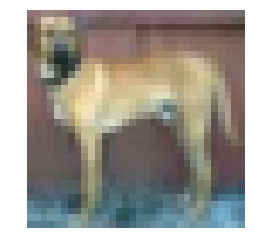

In [10]:
present_sample(train_batches[0], 7164)

#### Split data into train, val , test sets

- data is already shuffled

- concat all batches together

In [11]:
train_data = list()
train_labels = list()
for batch in train_batches:
    for data, label in zip(batch[DATA_I], batch[LABELS_I]):
        train_data.append(data)
        train_labels.append(label)
assert len(train_data) == len(train_labels)
        
test_data = list()
test_labels = list()
for data, label in zip(test_batch[DATA_I], test_batch[LABELS_I]):
    test_data.append(data)
    test_labels.append(label)
assert len(test_data) == len(test_labels)

- split data

In [12]:
split_ratio = 0.2
split_index = int(len(train_data) * split_ratio)

val_data = train_data[:split_index]
val_labels = train_labels[:split_index]

train_data = train_data[split_index:]
train_labels = train_labels[split_index:]

In [13]:
print("Train samples: " + str(len(train_data)))
print("Validation samples: " + str(len(val_data)))
print("Test samples: " + str(len(test_data)))

Train samples: 40000
Validation samples: 10000
Test samples: 10000


#### Preprocess data

In [14]:
def normalize(data):
    return data / MAX_PIXEL_VALUE

def ohe_label(label):
    labels_num = len(LABELS)
  
    encoding_array = np.zeros([labels_num])  
    encoding_array[label] = 1
        
    return encoding_array

In [15]:
train_data_norm = [normalize(data) for data in train_data]
train_labels_ohe = [ohe_label(label) for label in train_labels]

val_data_norm = [normalize(data) for data in val_data]
val_labels_ohe = [ohe_label(label) for label in val_labels]

test_data_norm = [normalize(data) for data in test_data]
test_labels_ohe = [ohe_label(label) for label in test_labels]

In [16]:
sample_to_inspect = 7124
sample = train_data_norm[sample_to_inspect]
label = train_labels_ohe[sample_to_inspect]
print("Sample no." + str(sample_to_inspect))
print("    - Min Value: {} Max Value: {}".format(sample.min(), sample.max()))
print("    - Label: " + str(label))

Sample no.7124
    - Min Value: 0.00784313725490196 Max Value: 0.9137254901960784
    - Label: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]


#### Building ConvNet - parts

In [17]:
def conv_net_image_input(image_width, image_height, channels):
    return tf.placeholder(tf.float32, shape=[None, image_width, image_height, channels], name='inputs')

In [18]:
def conv_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=[None, n_classes], name='labels')

In [19]:
def conv_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

In [20]:
def conv2d(tensor, layers, kernel_size, strides, activation,
           weights_init_mean=0.0, weights_init_stddev=0.08, padding="SAME"):
    
    weights_shape = (kernel_size[0], kernel_size[1], int(tensor.get_shape()[3]), layers)
    weights = tf.Variable(tf.truncated_normal(weights_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    
    bias_shape = [layers]
    bias = tf.Variable(tf.truncated_normal(bias_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    
    conv = tf.nn.conv2d(tensor, weights, strides=strides, padding=padding)
    conv_with_bias = tf.nn.bias_add(conv, bias)
    
    return activation(conv_with_bias)

In [21]:
def max_pool(tensor, kernel, strides, padding="SAME"):
    return tf.nn.max_pool(tensor, ksize=kernel, strides=strides, padding=padding)

In [22]:
def flatten(tensor):
    conv_output_shape = tensor.get_shape().as_list()
    return tf.reshape(tensor, [-1, conv_output_shape[1] * conv_output_shape[2] * conv_output_shape[3]])

In [23]:
def fully_conn(tensor, layer_size, activation, weights_init_mean=0.0, weights_init_stddev=0.08):
    weights_shape = (int(tensor.get_shape()[1]), layer_size)
    weights = tf.Variable(tf.truncated_normal(weights_shape, mean=weights_init_mean, stddev=weights_init_stddev)) 
    
    bias_shape = [layer_size]
    bias = tf.Variable(tf.truncated_normal(bias_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    layer = tf.nn.bias_add(tf.matmul(tensor, weights), bias)    
    
    return activation(layer)

In [24]:
def output(tensor, layer_size, weights_init_mean=0.0, weights_init_stddev=0.08):
    weights_size = (int(tensor.get_shape()[1]), layer_size)
    weights = tf.Variable(tf.truncated_normal(weights_size, mean=weights_init_mean, stddev=weights_init_stddev)) 
    
    bias_shape = [layer_size]
    bias = tf.Variable(tf.truncated_normal(bias_shape, mean=weights_init_mean, stddev=weights_init_stddev))
    output_layer = tf.nn.bias_add(tf.matmul(tensor, weights), bias)    
    
    return output_layer

In [25]:
def conv_net(x, keep_prob):   
    kernel_size_3x3 = 3, 3
    kernel_size_2x2 = [1, 2, 2, 1]
    strides_1x1x1x1 = [1, 1, 1, 1]
    strides_1x2x2x1 = [1, 2, 2, 1]
    
    # Conv Layer - 1, Input 32x32x3 -> MaxPool 2x2 -> Dropout -> Output 16x16x32
    conv1_layer = conv2d(x, 32, kernel_size_3x3, strides_1x1x1x1, tf.nn.elu)
    conv1_layer_mpool = max_pool(conv1_layer, kernel_size_2x2, strides_1x2x2x1)
    conv1_layer_dropout = tf.nn.dropout(conv1_layer_mpool, keep_prob)
    
    # Conv Layer - 2, Input 16x16x32 -> MaxPool 2x2 -> Dropout -> Output 8x8x32
    conv2_layer = conv2d(conv1_layer_dropout, 32, kernel_size_3x3, strides_1x1x1x1, tf.nn.elu)
    conv2_layer_mpool = max_pool(conv2_layer, kernel_size_2x2, strides_1x2x2x1)
    conv2_layer_dropout = tf.nn.dropout(conv2_layer_mpool, keep_prob)
    
    # Conv Layer - 3, Input 8x8x32 -> MaxPool 2x2 -> Dropout -> Output 4x4x64
    conv3_layer = conv2d(conv2_layer_dropout, 64, kernel_size_3x3, strides_1x1x1x1, tf.nn.elu)
    conv3_layer_mpool = max_pool(conv3_layer, kernel_size_2x2, strides_1x2x2x1)
    conv3_layer_dropout = tf.nn.dropout(conv3_layer_mpool, keep_prob)
    
    # Dense Layer - 1, Size 384 -> Dropout
    flatten_conv_output = flatten(conv3_layer_dropout)
    con1_layer = fully_conn(flatten_conv_output, 384, tf.nn.elu)
    con1_layer_dropout = tf.nn.dropout(con1_layer, keep_prob)
    
    # Dense Layer - 2, Size 128 -> Dropout
    con2_layer = fully_conn(con1_layer_dropout, 128, tf.nn.elu)
    con2_layer_dropout = tf.nn.dropout(con2_layer, keep_prob)

    return output(con2_layer_dropout, NUM_CLASSES)

#### Batch utils

In [26]:
def prepare_mini_batches(data, labels, batch_size):
    assert len(data) == len(labels)
    
    all_batches = list()
    for i in range(0, len(data)):
        all_batches.append((data[i], labels[i]))
    random.shuffle(all_batches)
        
    mini_batches = list()
    while len(all_batches) >= batch_size:
        
        data_batch = list()
        labels_batch = list()
        for j in range(0, batch_size):
            data, labels = all_batches.pop()
            data_batch.append(data)
            labels_batch.append(labels)
            
        mini_batches.append((np.array(data_batch), np.array(labels_batch)))
    
    return mini_batches

#### Building ConvNet - assemble

- Reset Tensorflow graph

In [27]:
tf.reset_default_graph()

- Assemble model

In [28]:
inputs = conv_net_image_input(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
targets = conv_net_label_input(NUM_CLASSES)
keep_prob = conv_net_keep_prob_input()

model = conv_net(inputs, keep_prob)

- Cost function, training optimizer, correct predictions, accuracy

In [29]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=targets))
optimizer = tf.train.AdamOptimizer().minimize(cost)
correct_pred = tf.equal(tf.argmax(model, 1), tf.argmax(targets, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

#### Hyperparameters

In [30]:
epochs = 110
batch_size = 256
keep_probability = 0.65

#### Training cycle

In [31]:
session = tf.Session()

In [32]:
session.run(tf.global_variables_initializer())

batch_count = 0
info = {'train_cost':[], 'train_acc':[], 'valid_cost':[], 'valid_acc':[]}
for epoch in range(epochs):
    mini_batches = prepare_mini_batches(train_data_norm, train_labels_ohe, batch_size)

    while mini_batches:
        data_batch, label_batch = mini_batches.pop()
        batch_count += 1

        session.run(optimizer, feed_dict={inputs: data_batch, 
                                          targets: label_batch, 
                                          keep_prob: keep_probability})
        if (batch_count % 50) == 0:
            train_cost = session.run(cost, feed_dict={
                    inputs: data_batch, targets: label_batch, keep_prob: 1.})

            train_acc = session.run(accuracy, feed_dict={
                inputs: data_batch, targets: label_batch, keep_prob: 1.})

            info["train_cost"].append(train_cost)
            info["train_acc"].append(train_acc)

            valid_cost = session.run(cost, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})

            valid_acc = session.run(accuracy, feed_dict={
                inputs: val_data_norm, targets: val_labels_ohe, keep_prob: 1.})

            info["valid_cost"].append(valid_cost)
            info["valid_acc"].append(valid_acc)

            print('Epoch {}, Batch {}:  '.format(epoch + 1, batch_count), end='')
            print("Train cost = ", "{:.4f},".format(train_cost), 
                  "Train acc = ", "{:.4f}".format(train_acc),
                  "Val cost = ", "{:.4f},".format(valid_cost), 
                  "Val acc = ", "{:.4f}".format(valid_acc))      

Epoch 1, Batch 50:  Train cost =  1.9324, Train acc =  0.2891 Val cost =  1.9443, Val acc =  0.2615
Epoch 1, Batch 100:  Train cost =  1.6951, Train acc =  0.3867 Val cost =  1.7297, Val acc =  0.3545
Epoch 1, Batch 150:  Train cost =  1.9492, Train acc =  0.2852 Val cost =  1.9246, Val acc =  0.3050
Epoch 2, Batch 200:  Train cost =  1.9677, Train acc =  0.3516 Val cost =  1.9926, Val acc =  0.3209
Epoch 2, Batch 250:  Train cost =  1.6036, Train acc =  0.4023 Val cost =  1.5955, Val acc =  0.4163
Epoch 2, Batch 300:  Train cost =  1.5686, Train acc =  0.4492 Val cost =  1.5699, Val acc =  0.4293
Epoch 3, Batch 350:  Train cost =  1.7496, Train acc =  0.4141 Val cost =  1.6801, Val acc =  0.4126
Epoch 3, Batch 400:  Train cost =  1.4986, Train acc =  0.4414 Val cost =  1.4801, Val acc =  0.4833
Epoch 3, Batch 450:  Train cost =  1.5564, Train acc =  0.4414 Val cost =  1.4628, Val acc =  0.4842
Epoch 4, Batch 500:  Train cost =  1.4856, Train acc =  0.4570 Val cost =  1.4303, Val acc =

Epoch 27, Batch 4100:  Train cost =  0.6929, Train acc =  0.7695 Val cost =  0.7344, Val acc =  0.7405
Epoch 27, Batch 4150:  Train cost =  0.6332, Train acc =  0.7695 Val cost =  0.7630, Val acc =  0.7320
Epoch 27, Batch 4200:  Train cost =  0.5277, Train acc =  0.8125 Val cost =  0.7533, Val acc =  0.7416
Epoch 28, Batch 4250:  Train cost =  0.6855, Train acc =  0.7656 Val cost =  0.7391, Val acc =  0.7401
Epoch 28, Batch 4300:  Train cost =  0.6052, Train acc =  0.7812 Val cost =  0.7191, Val acc =  0.7505
Epoch 28, Batch 4350:  Train cost =  0.6227, Train acc =  0.7852 Val cost =  0.7578, Val acc =  0.7361
Epoch 29, Batch 4400:  Train cost =  0.5544, Train acc =  0.7891 Val cost =  0.7309, Val acc =  0.7473
Epoch 29, Batch 4450:  Train cost =  0.6333, Train acc =  0.7773 Val cost =  0.7197, Val acc =  0.7451
Epoch 29, Batch 4500:  Train cost =  0.5204, Train acc =  0.8203 Val cost =  0.7017, Val acc =  0.7542
Epoch 30, Batch 4550:  Train cost =  0.6893, Train acc =  0.7539 Val cost

Epoch 52, Batch 8100:  Train cost =  0.3654, Train acc =  0.8789 Val cost =  0.6065, Val acc =  0.7842
Epoch 53, Batch 8150:  Train cost =  0.3486, Train acc =  0.8828 Val cost =  0.6298, Val acc =  0.7796
Epoch 53, Batch 8200:  Train cost =  0.4191, Train acc =  0.8438 Val cost =  0.6434, Val acc =  0.7776
Epoch 53, Batch 8250:  Train cost =  0.4320, Train acc =  0.8516 Val cost =  0.6488, Val acc =  0.7794
Epoch 54, Batch 8300:  Train cost =  0.4627, Train acc =  0.8398 Val cost =  0.6485, Val acc =  0.7708
Epoch 54, Batch 8350:  Train cost =  0.3928, Train acc =  0.8594 Val cost =  0.6284, Val acc =  0.7836
Epoch 54, Batch 8400:  Train cost =  0.5607, Train acc =  0.8125 Val cost =  0.6915, Val acc =  0.7639
Epoch 55, Batch 8450:  Train cost =  0.3471, Train acc =  0.8906 Val cost =  0.6588, Val acc =  0.7704
Epoch 55, Batch 8500:  Train cost =  0.3413, Train acc =  0.8945 Val cost =  0.6189, Val acc =  0.7873
Epoch 55, Batch 8550:  Train cost =  0.3012, Train acc =  0.9062 Val cost

Epoch 78, Batch 12100:  Train cost =  0.3471, Train acc =  0.8828 Val cost =  0.6281, Val acc =  0.7885
Epoch 78, Batch 12150:  Train cost =  0.2441, Train acc =  0.9297 Val cost =  0.6248, Val acc =  0.7904
Epoch 79, Batch 12200:  Train cost =  0.2724, Train acc =  0.9102 Val cost =  0.5881, Val acc =  0.7990
Epoch 79, Batch 12250:  Train cost =  0.2720, Train acc =  0.8945 Val cost =  0.5971, Val acc =  0.7960
Epoch 79, Batch 12300:  Train cost =  0.2780, Train acc =  0.8984 Val cost =  0.6025, Val acc =  0.7977
Epoch 80, Batch 12350:  Train cost =  0.2589, Train acc =  0.9180 Val cost =  0.6213, Val acc =  0.7917
Epoch 80, Batch 12400:  Train cost =  0.3074, Train acc =  0.8945 Val cost =  0.6102, Val acc =  0.7962
Epoch 80, Batch 12450:  Train cost =  0.3327, Train acc =  0.8906 Val cost =  0.6008, Val acc =  0.7975
Epoch 81, Batch 12500:  Train cost =  0.3176, Train acc =  0.8789 Val cost =  0.6070, Val acc =  0.7958
Epoch 81, Batch 12550:  Train cost =  0.3152, Train acc =  0.906

Epoch 103, Batch 16050:  Train cost =  0.1698, Train acc =  0.9805 Val cost =  0.5759, Val acc =  0.8048
Epoch 104, Batch 16100:  Train cost =  0.2176, Train acc =  0.9297 Val cost =  0.6238, Val acc =  0.7890
Epoch 104, Batch 16150:  Train cost =  0.2293, Train acc =  0.9375 Val cost =  0.6044, Val acc =  0.7973
Epoch 104, Batch 16200:  Train cost =  0.2394, Train acc =  0.9141 Val cost =  0.5863, Val acc =  0.8000
Epoch 105, Batch 16250:  Train cost =  0.2205, Train acc =  0.9336 Val cost =  0.5976, Val acc =  0.7967
Epoch 105, Batch 16300:  Train cost =  0.1864, Train acc =  0.9531 Val cost =  0.5985, Val acc =  0.7972
Epoch 105, Batch 16350:  Train cost =  0.2345, Train acc =  0.9180 Val cost =  0.6162, Val acc =  0.7972
Epoch 106, Batch 16400:  Train cost =  0.2583, Train acc =  0.9180 Val cost =  0.5947, Val acc =  0.8011
Epoch 106, Batch 16450:  Train cost =  0.1879, Train acc =  0.9414 Val cost =  0.6074, Val acc =  0.7938
Epoch 106, Batch 16500:  Train cost =  0.2162, Train ac

#### Results

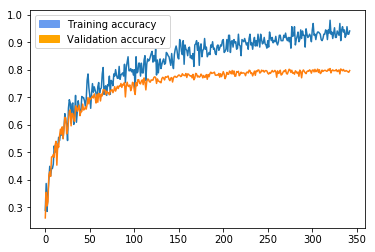

In [33]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(info['train_acc'], label='Training acc')
ax1.plot(info['valid_acc'], label='Validation acc')
blue_patch = mpatches.Patch(color='#699cef', label='Training accuracy')
orange_patch = mpatches.Patch(color='orange', label='Validation accuracy')
ax1.legend(handles=[blue_patch, orange_patch])
plt.show()

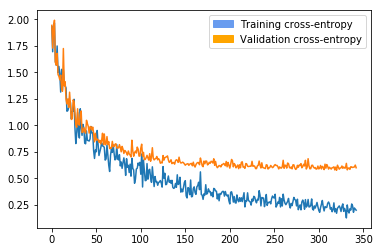

In [34]:
fig1 = plt.figure()
ax2 = fig1.add_subplot(111)
ax2.plot(info['train_cost'], label='Training loss')
ax2.plot(info['valid_cost'], label='Validation loss')
blue_patch = mpatches.Patch(color='#699cef', label='Training cross-entropy')
orange_patch = mpatches.Patch(color='orange', label='Validation cross-entropy')
ax2.legend(handles=[blue_patch, orange_patch])
plt.show()

#### Test accuracy

In [35]:
test_acc = session.run(accuracy, feed_dict={inputs: test_data_norm, 
                                            targets: test_labels_ohe, 
                                            keep_prob: 1.})
print("Test data accuracy: " + str(test_acc))

Test data accuracy: 0.7944


In [36]:
session.close()